In [1]:
import numpy as np
import pandas as pd
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import collections
import lightgbm
from lightgbm import *

pd.set_option("display.max_column", 999)
#print(os.listdir("../input"))

# Loading and preparing the data

In [2]:
tourney_results = pd.read_csv('WNCAATourneyDetailedResults.csv')
seeds = pd.read_csv('WNCAATourneySeeds.csv')
regular_results = pd.read_csv('WRegularSeasonDetailedResults.csv')

In [3]:
def prepare_data(df):
    dfswap = df[['Season', 'DayNum', 'LTeamID', 'LScore', 'WTeamID', 'WScore', 'WLoc', 'NumOT', 
    'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 
    'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF']]

    dfswap.loc[df['WLoc'] == 'H', 'WLoc'] = 'A'
    dfswap.loc[df['WLoc'] == 'A', 'WLoc'] = 'H'
    df.columns.values[6] = 'location'
    dfswap.columns.values[6] = 'location'    
      
    df.columns = [x.replace('W','T1_').replace('L','T2_') for x in list(df.columns)]
    dfswap.columns = [x.replace('L','T1_').replace('W','T2_') for x in list(dfswap.columns)]

    output = pd.concat([df, dfswap]).reset_index(drop=True)
    output.loc[output.location=='N','location'] = '0'
    output.loc[output.location=='H','location'] = '1'
    output.loc[output.location=='A','location'] = '-1'
    output.location = output.location.astype(int)
    
    output['PointDiff'] = output['T1_Score'] - output['T2_Score']
    
    return output

In [4]:
regular_data = prepare_data(regular_results)
tourney_data = prepare_data(tourney_results)

In [5]:
regular_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2010,11,3103,63,3237,49,1,0,23,54,5,9,12,19,10,26,14,18,7,0,15,20,54,3,13,6,10,11,27,11,23,7,6,19,14
1,2010,11,3104,73,3399,68,0,0,26,62,5,12,16,28,16,31,15,20,5,2,25,25,63,4,21,14,27,14,26,7,20,4,2,27,5
2,2010,11,3110,71,3224,59,-1,0,29,62,6,15,7,12,14,23,18,13,6,2,17,19,58,2,14,19,23,17,23,8,15,6,0,15,12
3,2010,11,3111,63,3267,58,-1,0,27,52,4,11,5,9,6,40,14,27,5,10,18,18,74,6,26,16,25,22,22,15,11,14,5,14,5
4,2010,11,3119,74,3447,70,1,1,30,74,7,20,7,11,14,33,18,11,5,3,18,25,74,9,17,11,21,21,32,12,14,4,2,14,4


In [6]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,location,NumOT,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_FTM,T1_FTA,T1_OR,T1_DR,T1_Ast,T1_TO,T1_Stl,T1_Blk,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_FTM,T2_FTA,T2_OR,T2_DR,T2_Ast,T2_TO,T2_Stl,T2_Blk,T2_PF,PointDiff
0,2010,138,3124,69,3201,55,0,0,28,57,1,5,12,19,13,24,22,12,6,2,12,21,61,10,34,3,5,17,19,12,18,4,1,18,14
1,2010,138,3173,67,3395,66,0,0,23,59,9,26,12,19,13,34,13,16,3,10,14,22,73,8,27,14,15,18,26,8,8,8,6,22,1
2,2010,138,3181,72,3214,37,1,0,26,57,4,13,16,22,13,34,15,11,10,7,11,15,56,4,15,3,8,10,21,4,16,6,4,20,35
3,2010,138,3199,75,3256,61,1,0,25,63,3,15,22,26,20,27,13,17,8,3,21,21,62,2,20,17,22,16,21,13,16,5,4,24,14
4,2010,138,3207,62,3265,42,0,0,24,68,8,25,6,8,20,29,16,8,5,5,18,13,60,5,26,11,17,16,22,9,10,3,4,12,20


# Feature engineering

In [7]:
boxscore_cols = ['T1_Score', 'T2_Score', 
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_FTM', 'T1_FTA', 'T1_OR', 'T1_DR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_Blk', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_FTM', 'T2_FTA', 'T2_OR', 'T2_DR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk', 'T2_PF', 
        'PointDiff']

boxscore_cols = [
        'T1_FGM', 'T1_FGA', 'T1_FGM3', 'T1_FGA3', 'T1_OR', 'T1_Ast', 'T1_TO', 'T1_Stl', 'T1_PF', 
        'T2_FGM', 'T2_FGA', 'T2_FGM3', 'T2_FGA3', 'T2_OR', 'T2_Ast', 'T2_TO', 'T2_Stl', 'T2_Blk',  
        'PointDiff']

In [8]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean])
season_statistics.head()

T1_FGM     T1_FGA   T1_FGM3    T1_FGA3      T1_OR  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2010   3102       19.142857  53.142857  4.571429  16.071429  12.464286   
       3103       22.233333  55.266667  3.933333  12.466667  14.200000   
       3104       24.724138  62.103448  4.344828  14.724138  14.482759   
       3105       20.370370  50.851852  3.037037   9.888889  13.666667   
       3106       18.448276  53.000000  2.689655   9.586207  15.000000   

                     T1_Ast      T1_TO    T1_Stl      T1_PF     T2_FGM  \
                       mean       mean      mean       mean       mean   
Season T1_TeamID                                                         
2010   3102       10.250000  17.714286  6.035714  14.964286  27.000000   
       3103       13.433333  18.266667  8.033333  17.533333  20.966667   
       3104       13.103448  19.172414  7.379310  20.413793  23.896552   
       3105        9.740741  25.037037  8.777778  19.148148  22.777778   
       3106       11.482759  20.103448  8.034483  22.068966  17.896552   

                     T2_FGA   T2_FGM3    T2_FGA3      T2_OR     T2_Ast  \
                       mean      mean       mean       mean       mean   
Season T1_TeamID                                                         
2010   3102       56.392857  7.714286  20.500000  12.821429  19.535714   
       3103       54.966667  4.833333  15.166667  13.633333  11.700000   
       3104       60.137931  5.103448  16.517241  14.862069  12.517241   
       3105       57.518519  3.740741  12.777778  15.185185  13.481481   
       3106       50.689655  3.724138  11.827586  12.379310   9.517241   

                      T2_TO     T2_Stl    T2_Blk  PointDiff  
                       mean       mean      mean       mean  
Season T1_TeamID                                             
2010   3102       14.392857   9.821429  5.035714 -19.964286  
       3103       18.700000   9.233333  3.800000   2.600000  
       3104       19.241379   8.758621  3.586207  -2.862069  
       3105       20.740741  12.222222  4.407407  -3.962963  
       3106       18.310345   8.793103  3.965517  -2.275862

In [9]:
season_statistics = regular_data.groupby(["Season", 'T1_TeamID'])[boxscore_cols].agg([np.mean]).reset_index()
season_statistics.head()

,Season,T1_TeamID,T1_FGM,T1_FGA,T1_FGM3,T1_FGA3,T1_OR,T1_Ast,T1_TO,T1_Stl,T1_PF,T2_FGM,T2_FGA,T2_FGM3,T2_FGA3,T2_OR,T2_Ast,T2_TO,T2_Stl,T2_Blk,PointDiff
,,,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
0,2010,3102,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,14.964286,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,17.533333,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,20.413793,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,25.037037,8.777778,19.148148,22.777778,57.518519,3.740741,12.777778,15.185185,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,20.103448,8.034483,22.068966,17.896552,50.689655,3.724138,11.827586,12.379310,9.517241,18.310345,8.793103,3.965517,-2.275862


In [10]:
season_statistics.columns = [''.join(col).strip() for col in season_statistics.columns.values]
season_statistics.head()

,Season,T1_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_Blkmean,PointDiffmean
0,2010,3102,19.142857,53.142857,4.571429,16.071429,12.464286,10.250000,17.714286,6.035714,14.964286,27.000000,56.392857,7.714286,20.500000,12.821429,19.535714,14.392857,9.821429,5.035714,-19.964286
1,2010,3103,22.233333,55.266667,3.933333,12.466667,14.200000,13.433333,18.266667,8.033333,17.533333,20.966667,54.966667,4.833333,15.166667,13.633333,11.700000,18.700000,9.233333,3.800000,2.600000
2,2010,3104,24.724138,62.103448,4.344828,14.724138,14.482759,13.103448,19.172414,7.379310,20.413793,23.896552,60.137931,5.103448,16.517241,14.862069,12.517241,19.241379,8.758621,3.586207,-2.862069
3,2010,3105,20.370370,50.851852,3.037037,9.888889,13.666667,9.740741,25.037037,8.777778,19.148148,22.777778,57.518519,3.740741,12.777778,15.185185,13.481481,20.740741,12.222222,4.407407,-3.962963
4,2010,3106,18.448276,53.000000,2.689655,9.586207,15.000000,11.482759,20.103448,8.034483,22.068966,17.896552,50.689655,3.724138,11.827586,12.379310,9.517241,18.310345,8.793103,3.965517,-2.275862


In [11]:
season_statistics_T1 = season_statistics.copy()
season_statistics_T2 = season_statistics.copy()

season_statistics_T1.columns = ["T1_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T1.columns)]
season_statistics_T2.columns = ["T2_" + x.replace("T1_","").replace("T2_","opponent_") for x in list(season_statistics_T2.columns)]
season_statistics_T1.columns.values[0] = "Season"
season_statistics_T2.columns.values[0] = "Season"

In [12]:
tourney_data = tourney_data[['Season', 'DayNum', 'T1_TeamID', 'T1_Score', 'T2_TeamID' ,'T2_Score']]
tourney_data = pd.merge(tourney_data, season_statistics_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, season_statistics_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [13]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean
0,2010,138,3124,69,3201,55,26.093750,56.343750,2.468750,8.656250,12.187500,14.687500,16.875000,6.968750,14.125000,21.125000,62.625000,5.531250,19.937500,12.687500,9.500000,15.718750,6.656250,1.875000,15.250000,25.848485,61.575758,8.818182,24.848485,13.878788,14.636364,15.636364,10.393939,16.393939,22.939394,56.696970,4.151515,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788
1,2010,138,3173,67,3395,66,25.884615,61.538462,5.461538,17.461538,14.730769,14.461538,16.961538,7.730769,16.576923,21.576923,58.692308,5.423077,16.846154,12.076923,11.653846,18.346154,7.615385,4.384615,11.269231,25.833333,62.266667,6.866667,19.200000,13.500000,15.600000,16.033333,9.833333,16.233333,21.833333,59.700000,5.733333,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000
2,2010,138,3181,72,3214,37,26.843750,63.750000,4.562500,14.468750,17.718750,14.250000,17.906250,13.375000,17.687500,18.843750,53.593750,5.312500,16.593750,12.500000,11.375000,23.218750,7.531250,3.281250,16.531250,22.200000,60.100000,4.900000,16.100000,14.966667,11.600000,15.533333,10.100000,18.833333,19.000000,49.933333,2.866667,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000
3,2010,138,3199,75,3256,61,26.400000,59.200000,6.100000,16.100000,14.400000,15.333333,19.033333,8.833333,17.133333,21.333333,59.566667,5.300000,18.433333,13.400000,12.233333,19.200000,8.200000,2.133333,14.366667,27.161290,62.516129,3.935484,12.451613,14.806452,14.516129,17.096774,7.096774,16.032258,23.903226,64.064516,4.806452,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484
4,2010,138,3207,62,3265,42,23.833333,60.266667,6.333333,20.066667,15.766667,15.866667,16.300000,13.366667,18.033333,19.733333,48.866667,5.400000,18.833333,12.100000,13.266667,24.600000,7.933333,3.233333,9.666667,23.424242,55.696970,6.545455,19.030303,10.515152,14.454545,13.484848,7.878788,13.969697,20.575758,58.939394,6.333333,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727


# Added winrate for last 2 weeks

In [14]:
last14days_stats_T1 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['PointDiff']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['Season','T1_TeamID'])['win'].mean().reset_index(name='T1_win_ratio_14d')

last14days_stats_T2 = regular_data.loc[regular_data.DayNum>118].reset_index(drop=True)
last14days_stats_T2['win'] = np.where(last14days_stats_T2['PointDiff']<0,1,0)
last14days_stats_T2 = last14days_stats_T2.groupby(['Season','T2_TeamID'])['win'].mean().reset_index(name='T2_win_ratio_14d')

In [15]:
tourney_data = pd.merge(tourney_data, last14days_stats_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, last14days_stats_T2, on = ['Season', 'T2_TeamID'], how = 'left')

In [16]:
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d
0,2010,138,3124,69,3201,55,26.093750,56.343750,2.468750,8.656250,12.187500,14.687500,16.875000,6.968750,14.125000,21.125000,62.625000,5.531250,19.937500,12.687500,9.500000,15.718750,6.656250,1.875000,15.250000,25.848485,61.575758,8.818182,24.848485,13.878788,14.636364,15.636364,10.393939,16.393939,22.939394,56.696970,4.151515,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788,0.5,0.750000
1,2010,138,3173,67,3395,66,25.884615,61.538462,5.461538,17.461538,14.730769,14.461538,16.961538,7.730769,16.576923,21.576923,58.692308,5.423077,16.846154,12.076923,11.653846,18.346154,7.615385,4.384615,11.269231,25.833333,62.266667,6.866667,19.200000,13.500000,15.600000,16.033333,9.833333,16.233333,21.833333,59.700000,5.733333,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000,0.5,0.333333
2,2010,138,3181,72,3214,37,26.843750,63.750000,4.562500,14.468750,17.718750,14.250000,17.906250,13.375000,17.687500,18.843750,53.593750,5.312500,16.593750,12.500000,11.375000,23.218750,7.531250,3.281250,16.531250,22.200000,60.100000,4.900000,16.100000,14.966667,11.600000,15.533333,10.100000,18.833333,19.000000,49.933333,2.866667,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000,1.0,1.000000
3,2010,138,3199,75,3256,61,26.400000,59.200000,6.100000,16.100000,14.400000,15.333333,19.033333,8.833333,17.133333,21.333333,59.566667,5.300000,18.433333,13.400000,12.233333,19.200000,8.200000,2.133333,14.366667,27.161290,62.516129,3.935484,12.451613,14.806452,14.516129,17.096774,7.096774,16.032258,23.903226,64.064516,4.806452,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484,0.0,0.800000
4,2010,138,3207,62,3265,42,23.833333,60.266667,6.333333,20.066667,15.766667,15.866667,16.300000,13.366667,18.033333,19.733333,48.866667,5.400000,18.833333,12.100000,13.266667,24.600000,7.933333,3.233333,9.666667,23.424242,55.696970,6.545455,19.030303,10.515152,14.454545,13.484848,7.878788,13.969697,20.575758,58.939394,6.333333,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727,0.5,1.000000


# Only playoffs teams in regular_season_effects

In [17]:
regular_season_effects = regular_data[['Season','T1_TeamID','T2_TeamID','PointDiff']].copy()
regular_season_effects['T1_TeamID'] = regular_season_effects['T1_TeamID'].astype(str)
regular_season_effects['T2_TeamID'] = regular_season_effects['T2_TeamID'].astype(str)
regular_season_effects['win'] = np.where(regular_season_effects['PointDiff']>0,1,0)
march_madness = pd.merge(seeds[['Season','TeamID']],seeds[['Season','TeamID']],on='Season')
march_madness.columns = ['Season', 'T1_TeamID', 'T2_TeamID']
march_madness.T1_TeamID = march_madness.T1_TeamID.astype(str)
march_madness.T2_TeamID = march_madness.T2_TeamID.astype(str)
regular_season_effects = pd.merge(regular_season_effects, march_madness, on = ['Season','T1_TeamID','T2_TeamID'])
regular_season_effects.head()

,Season,T1_TeamID,T2_TeamID,PointDiff,win
0,2010,3173,3277,3,1
1,2010,3190,3151,24,1
2,2010,3329,3114,9,1
3,2010,3355,3211,4,1
4,2010,3436,3301,5,1


In [18]:
seeds.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


In [19]:
seeds['seed'] = seeds['Seed'].apply(lambda x: int(x[1:3]))
seeds_T1 = seeds[['Season','TeamID','seed']].copy()
seeds_T2 = seeds[['Season','TeamID','seed']].copy()
seeds_T1.columns = ['Season','T1_TeamID','T1_seed']
seeds_T2.columns = ['Season','T2_TeamID','T2_seed']

In [20]:
tourney_data = pd.merge(tourney_data, seeds_T1, on = ['Season', 'T1_TeamID'], how = 'left')
tourney_data = pd.merge(tourney_data, seeds_T2, on = ['Season', 'T2_TeamID'], how = 'left')
tourney_data["Seed_diff"] = tourney_data["T1_seed"] - tourney_data["T2_seed"]
tourney_data.head()

,Season,DayNum,T1_TeamID,T1_Score,T2_TeamID,T2_Score,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_win_ratio_14d,T2_win_ratio_14d,T1_seed,T2_seed,Seed_diff
0,2010,138,3124,69,3201,55,26.093750,56.343750,2.468750,8.656250,12.187500,14.687500,16.875000,6.968750,14.125000,21.125000,62.625000,5.531250,19.937500,12.687500,9.500000,15.718750,6.656250,1.875000,15.250000,25.848485,61.575758,8.818182,24.848485,13.878788,14.636364,15.636364,10.393939,16.393939,22.939394,56.696970,4.151515,13.848485,12.242424,11.848485,19.878788,6.757576,2.606061,12.878788,0.5,0.750000,4,13,-9
1,2010,138,3173,67,3395,66,25.884615,61.538462,5.461538,17.461538,14.730769,14.461538,16.961538,7.730769,16.576923,21.576923,58.692308,5.423077,16.846154,12.076923,11.653846,18.346154,7.615385,4.384615,11.269231,25.833333,62.266667,6.866667,19.200000,13.500000,15.600000,16.033333,9.833333,16.233333,21.833333,59.700000,5.733333,20.166667,14.866667,13.466667,20.666667,8.466667,3.500000,12.000000,0.5,0.333333,8,9,-1
2,2010,138,3181,72,3214,37,26.843750,63.750000,4.562500,14.468750,17.718750,14.250000,17.906250,13.375000,17.687500,18.843750,53.593750,5.312500,16.593750,12.500000,11.375000,23.218750,7.531250,3.281250,16.531250,22.200000,60.100000,4.900000,16.100000,14.966667,11.600000,15.533333,10.100000,18.833333,19.000000,49.933333,2.866667,10.333333,12.633333,8.733333,22.133333,6.633333,2.266667,7.700000,1.0,1.000000,2,15,-13
3,2010,138,3199,75,3256,61,26.400000,59.200000,6.100000,16.100000,14.400000,15.333333,19.033333,8.833333,17.133333,21.333333,59.566667,5.300000,18.433333,13.400000,12.233333,19.200000,8.200000,2.133333,14.366667,27.161290,62.516129,3.935484,12.451613,14.806452,14.516129,17.096774,7.096774,16.032258,23.903226,64.064516,4.806452,17.387097,13.709677,10.741935,17.451613,8.193548,4.225806,9.935484,0.0,0.800000,3,14,-11
4,2010,138,3207,62,3265,42,23.833333,60.266667,6.333333,20.066667,15.766667,15.866667,16.300000,13.366667,18.033333,19.733333,48.866667,5.400000,18.833333,12.100000,13.266667,24.600000,7.933333,3.233333,9.666667,23.424242,55.696970,6.545455,19.030303,10.515152,14.454545,13.484848,7.878788,13.969697,20.575758,58.939394,6.333333,21.363636,14.333333,10.727273,15.727273,7.151515,2.303030,10.272727,0.5,1.000000,5,12,-7


In [21]:
tourney_data.shape

(1134, 49)

In [22]:
y = tourney_data['T1_Score'] - tourney_data['T2_Score']

In [23]:
features = list(season_statistics_T1.columns[2:]) + \
    list(season_statistics_T2.columns[2:]) + \
    list(seeds_T1.columns[2:]) + \
    list(seeds_T2.columns[2:]) + \
    list(last14days_stats_T1.columns[2:]) + \
    list(last14days_stats_T2.columns[2:]) + \
    ["Seed_diff"] 

In [24]:
len(features)

43

In [25]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


# Defining loss

In [26]:
def cauchyobj(preds, dtrain):
    labels = dtrain.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [27]:
param = {} 
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.02
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3
param['silent'] = 1

In [28]:
xgb_cv = []
repeat_cv = 5 

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.9565+0.183543	test-mae:16.9636+0.734783
[50]	train-mae:11.9024+0.125434	test-mae:12.2301+0.664179
[100]	train-mae:10.5589+0.0913597	test-mae:11.1161+0.577635
[150]	train-mae:9.9997+0.0698815	test-mae:10.7897+0.499677
[200]	train-mae:9.63456+0.0685963	test-mae:10.6395+0.475671
[250]	train-mae:9.35721+0.071361	test-mae:10.5589+0.454151
[300]	train-mae:9.12029+0.0754092	test-mae:10.5207+0.446246
[350]	train-mae:8.91295+0.0825592	test-mae:10.4976+0.447233
[400]	train-mae:8.72406+0.0895132	test-mae:10.4855+0.445498
[450]	train-mae:8.55133+0.0898575	test-mae:10.4777+0.443577
Fold repeater 1
[0]	train-mae:16.9568+0.171383	test-mae:16.9622+0.684129
[50]	train-mae:11.9002+0.158277	test-mae:12.2103+0.806852
[100]	train-mae:10.5588+0.16712	test-mae:11.0914+0.740026
[150]	train-mae:9.99711+0.162723	test-mae:10.739+0.689526
[200]	train-mae:9.62942+0.15712	test-mae:10.5814+0.648544
[250]	train-mae:9.34824+0.145155	test-mae:10.51+0.606872
[300]	train-mae:9.1152+0.1389

In [29]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([455, 444, 406, 447, 450],
 [10.477113399999999,
  10.430741399999999,
  10.454715400000001,
  10.3826968,
  10.4205754])

In [40]:
oof_preds = []
models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
        models.append(model)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [60]:
all_models = []
for i in models:
    all_models.append(i.get_fscore())

In [96]:
import collections 
counter = collections.Counter() 
for d in all_models:  
    counter.update(d)       
result = dict(counter) 
print(str(counter)) 

Counter({'f42': 30860, 'f37': 18396, 'f18': 18065, 'f5': 15722, 'f24': 15438, 'f39': 14758, 'f38': 14692, 'f0': 14508, 'f19': 14334, 'f9': 11283, 'f28': 10819, 'f32': 10629, 'f13': 10558, 'f36': 9021, 'f8': 8909, 'f17': 8881, 'f27': 8831, 'f7': 8739, 'f34': 8729, 'f15': 8636, 'f26': 8558, 'f40': 8490, 'f41': 8432, 'f12': 8357, 'f31': 8301, 'f23': 7869, 'f16': 7612, 'f4': 7564, 'f35': 7561, 'f25': 7497, 'f6': 7486, 'f1': 7303, 'f14': 7262, 'f20': 7160, 'f33': 6911, 'f21': 6411, 'f2': 6344, 'f3': 6104, 'f22': 6090, 'f30': 5816, 'f11': 5816, 'f29': 5806, 'f10': 5792})


In [133]:
sorted_counter = sorted(result.items(), key=lambda kv: kv[1])
delet_features = []
for i in range(len(sorted_counter)-30):
    delet_features.append(sorted_counter[i][0])
old_features = features.copy()
for i in delet_features:
    aaaa = str(i)
    bbbb = int(aaaa[1:])
    cccc = old_features[bbbb]
    features.remove(cccc)

In [149]:
X = tourney_data[features].values
dtrain = xgb.DMatrix(X, label = y)

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [150]:
xgb_cv = []
repeat_cv = 5 

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = dtrain,
          obj = cauchyobj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:16.9535+0.182154	test-mae:16.9606+0.739419
[50]	train-mae:11.8892+0.135505	test-mae:12.2073+0.647796
[100]	train-mae:10.5549+0.0990477	test-mae:11.078+0.557478
[150]	train-mae:9.9991+0.0760374	test-mae:10.7365+0.49267
[200]	train-mae:9.64081+0.0758537	test-mae:10.5806+0.453692
[250]	train-mae:9.36852+0.0809261	test-mae:10.4884+0.438579
[300]	train-mae:9.1471+0.0830271	test-mae:10.4441+0.42458
[350]	train-mae:8.94896+0.0852226	test-mae:10.4157+0.42814
[400]	train-mae:8.77925+0.0856651	test-mae:10.4061+0.428893
[450]	train-mae:8.61929+0.0853584	test-mae:10.4019+0.43331
Fold repeater 1
[0]	train-mae:16.9551+0.170946	test-mae:16.9604+0.686713
[50]	train-mae:11.8963+0.158733	test-mae:12.195+0.801525
[100]	train-mae:10.5553+0.163126	test-mae:11.0867+0.744127
[150]	train-mae:9.99821+0.156544	test-mae:10.726+0.691218
[200]	train-mae:9.63533+0.14786	test-mae:10.5659+0.644333
[250]	train-mae:9.36409+0.141522	test-mae:10.4906+0.612593
[300]	train-mae:9.14308+0.132541

In [151]:
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([431, 424, 422, 463, 470],
 [10.397725600000001,
  10.389465399999999,
  10.3609324,
  10.2886796,
  10.322350799999999])

In [152]:
oof_preds = []
models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
        models.append(model)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0


C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


### xgB probability/Final difference

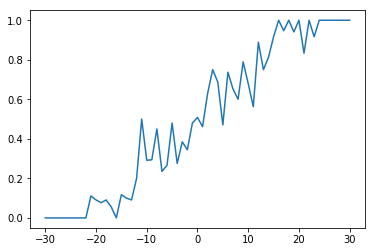

In [153]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [154]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.427058918025615
logloss of cvsplit 1: 0.4235966812292904
logloss of cvsplit 2: 0.4238374260776126
logloss of cvsplit 3: 0.4203417477353739
logloss of cvsplit 4: 0.4226567413991604


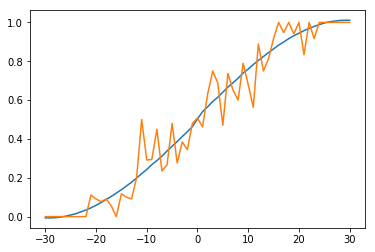

In [155]:
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')['spline','label'].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [156]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4310644865051852
adjusted logloss of cvsplit 1: 0.427533694309597
adjusted logloss of cvsplit 2: 0.4273964154982544
adjusted logloss of cvsplit 3: 0.4249039137092007
adjusted logloss of cvsplit 4: 0.42704023484864123


In [157]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.47133690356026514
adjusted logloss of cvsplit 1: 0.46924167302301684
adjusted logloss of cvsplit 2: 0.46937982860571265
adjusted logloss of cvsplit 3: 0.4664947574161614
adjusted logloss of cvsplit 4: 0.4675789941528516


In [158]:
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

adjusted logloss of cvsplit 0: 0.4159894081412565
adjusted logloss of cvsplit 1: 0.4124410090450432
adjusted logloss of cvsplit 2: 0.41315873934135794
adjusted logloss of cvsplit 3: 0.40989959399074344
adjusted logloss of cvsplit 4: 0.41165807350463385


In [159]:
val_cv = []
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    spline_fit[(tourney_data.T1_seed==1) & (tourney_data.T2_seed==16) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==2) & (tourney_data.T2_seed==15) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==3) & (tourney_data.T2_seed==14) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==4) & (tourney_data.T2_seed==13) & (tourney_data.T1_Score > tourney_data.T2_Score)] = 1.0
    spline_fit[(tourney_data.T1_seed==16) & (tourney_data.T2_seed==1) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==15) & (tourney_data.T2_seed==2) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==14) & (tourney_data.T2_seed==3) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    spline_fit[(tourney_data.T1_seed==13) & (tourney_data.T2_seed==4) & (tourney_data.T1_Score < tourney_data.T2_Score)] = 0.0
    
    val_cv.append(pd.DataFrame({"y":np.where(y>0,1,0), "pred":spline_fit, "season":tourney_data.Season}))
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 
    
val_cv = pd.concat(val_cv)
val_cv.groupby('season').apply(lambda x: log_loss(x.y, x.pred))

adjusted logloss of cvsplit 0: 0.4159894081412565
adjusted logloss of cvsplit 1: 0.4124410090450432
adjusted logloss of cvsplit 2: 0.41315873934135794
adjusted logloss of cvsplit 3: 0.40989959399074344
adjusted logloss of cvsplit 4: 0.41165807350463385


season
2010    0.402693
2011    0.370604
2012    0.409828
2013    0.410270
2014    0.396552
2015    0.343469
2016    0.490258
2017    0.467465
2018    0.422525
dtype: float64

# Submission 

In [160]:
sub = pd.read_csv('WSampleSubmissionStage2.csv')
sub["Season"] = sub["ID"].apply(lambda x: x[0:4]).astype(int)
sub["T1_TeamID"] = sub["ID"].apply(lambda x: x[5:9]).astype(int)
sub["T2_TeamID"] = sub["ID"].apply(lambda x: x[10:14]).astype(int)
sub.shape

(2016, 5)

In [161]:
sub = pd.merge(sub, season_statistics_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, season_statistics_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, seeds_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T2, on = ['Season', 'T2_TeamID'])
sub = pd.merge(sub, last14days_stats_T1, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, last14days_stats_T2, on = ['Season', 'T2_TeamID'])
sub["Seed_diff"] = sub["T1_seed"] - sub["T2_seed"]
sub.shape

(2016, 48)

In [162]:
Xsub = sub[features].values
dtest = xgb.DMatrix(Xsub)

In [163]:
sub_models = []
for i in range(5):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = dtrain,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4


In [164]:
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,T1_FGMmean,T1_FGAmean,T1_FGM3mean,T1_FGA3mean,T1_ORmean,T1_Astmean,T1_TOmean,T1_Stlmean,T1_PFmean,T1_opponent_FGMmean,T1_opponent_FGAmean,T1_opponent_FGM3mean,T1_opponent_FGA3mean,T1_opponent_ORmean,T1_opponent_Astmean,T1_opponent_TOmean,T1_opponent_Stlmean,T1_opponent_Blkmean,T1_PointDiffmean,T2_FGMmean,T2_FGAmean,T2_FGM3mean,T2_FGA3mean,T2_ORmean,T2_Astmean,T2_TOmean,T2_Stlmean,T2_PFmean,T2_opponent_FGMmean,T2_opponent_FGAmean,T2_opponent_FGM3mean,T2_opponent_FGA3mean,T2_opponent_ORmean,T2_opponent_Astmean,T2_opponent_TOmean,T2_opponent_Stlmean,T2_opponent_Blkmean,T2_PointDiffmean,T1_seed,T2_seed,T1_win_ratio_14d,T2_win_ratio_14d,Seed_diff
0,2019_3101_3113,0.5,2019,3101,3113,25.535714,54.785714,7.892857,23.571429,11.357143,16.464286,18.214286,7.321429,18.821429,23.178571,56.964286,5.571429,18.107143,11.714286,13.357143,14.392857,9.321429,2.392857,6.392857,25.100000,59.233333,5.933333,18.566667,13.400000,15.866667,12.333333,6.633333,15.166667,21.966667,54.266667,4.466667,14.433333,8.900000,9.700000,13.366667,5.766667,2.300000,8.100000,16,5,0.8,0.5,11
1,2019_3101_3114,0.5,2019,3101,3114,25.535714,54.785714,7.892857,23.571429,11.357143,16.464286,18.214286,7.321429,18.821429,23.178571,56.964286,5.571429,18.107143,11.714286,13.357143,14.392857,9.321429,2.392857,6.392857,23.612903,54.645161,3.193548,9.677419,10.580645,14.000000,13.870968,6.677419,17.096774,20.935484,51.903226,3.548387,11.387097,10.870968,8.903226,17.000000,4.903226,2.322581,5.225806,16,12,0.8,1.0,4
2,2019_3113_3114,0.5,2019,3113,3114,25.100000,59.233333,5.933333,18.566667,13.400000,15.866667,12.333333,6.633333,15.166667,21.966667,54.266667,4.466667,14.433333,8.900000,9.700000,13.366667,5.766667,2.300000,8.100000,23.612903,54.645161,3.193548,9.677419,10.580645,14.000000,13.870968,6.677419,17.096774,20.935484,51.903226,3.548387,11.387097,10.870968,8.903226,17.000000,4.903226,2.322581,5.225806,5,12,0.5,1.0,-7
3,2019_3101_3120,0.5,2019,3101,3120,25.535714,54.785714,7.892857,23.571429,11.357143,16.464286,18.214286,7.321429,18.821429,23.178571,56.964286,5.571429,18.107143,11.714286,13.357143,14.392857,9.321429,2.392857,6.392857,26.333333,62.533333,5.966667,18.733333,13.166667,12.100000,13.066667,12.166667,18.400000,22.000000,52.633333,7.133333,20.366667,11.233333,13.400000,21.066667,7.100000,2.200000,8.233333,16,10,0.8,0.5,6
4,2019_3113_3120,0.5,2019,3113,3120,25.100000,59.233333,5.933333,18.566667,13.400000,15.866667,12.333333,6.633333,15.166667,21.966667,54.266667,4.466667,14.433333,8.900000,9.700000,13.366667,5.766667,2.300000,8.100000,26.333333,62.533333,5.966667,18.733333,13.166667,12.100000,13.066667,12.166667,18.400000,22.000000,52.633333,7.133333,20.366667,11.233333,13.400000,21.066667,7.100000,2.200000,8.233333,5,10,0.5,0.5,-5


In [165]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 0.99
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 0.985
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 0.96
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 0.9
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.01
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.015
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.04
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.1

sub[['ID','Pred']].to_csv("paris-women-submission.csv", index = None)

In [166]:
seeds["Seed"] = seeds["Seed"].astype(str)
seeds["Seed"] = seeds["Seed"].apply(lambda x: x[0])
seeds_T11 = seeds[['Season','TeamID','Seed']].copy()
seeds_T22 = seeds[['Season','TeamID','Seed']].copy()
seeds_T11.columns = ['Season','T1_TeamID','T1_seed']
seeds_T22.columns = ['Season','T2_TeamID','T2_seed']

In [167]:
sub = pd.merge(sub, seeds_T11, on = ['Season', 'T1_TeamID'])
sub = pd.merge(sub, seeds_T22, on = ['Season', 'T2_TeamID'])

In [168]:
sub.loc[(sub.T1_seed_y=='W') & (sub.T2_seed_y=='Y'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='W') & (sub.T2_seed_y=='Z'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='X') & (sub.T2_seed_y=='Y'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='X') & (sub.T2_seed_y=='Z'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='Y') & (sub.T2_seed_y=='W'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='Y') & (sub.T2_seed_y=='X'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='Z') & (sub.T2_seed_y=='W'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='Z') & (sub.T2_seed_y=='X'), 'Pred'] = 0
sub[['ID','Pred']].to_csv("paris-women-submission-1.csv", index = None)

sub.loc[(sub.T1_seed_y=='W') & (sub.T2_seed_y=='Y'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='W') & (sub.T2_seed_y=='Z'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='X') & (sub.T2_seed_y=='Y'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='X') & (sub.T2_seed_y=='Z'), 'Pred'] = 0
sub.loc[(sub.T1_seed_y=='Y') & (sub.T2_seed_y=='W'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='Y') & (sub.T2_seed_y=='X'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='Z') & (sub.T2_seed_y=='W'), 'Pred'] = 1
sub.loc[(sub.T1_seed_y=='Z') & (sub.T2_seed_y=='X'), 'Pred'] = 1
sub[['ID','Pred']].to_csv("paris-women-submission-2.csv", index = None)